In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math

In [2]:
names_reanalyses = ['ERA5',
                   'JRA3Q',
                   'NCEP_NCAR']

In [3]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'
path_pcs = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/PCs_Z500/'

# First compute WRs for ERA5

In [4]:
reanalysis = 'ERA5'
pcs = pd.read_csv(f'{path_pcs}/PCs_{reanalysis}_corrected.csv',
                  index_col=0,parse_dates=True, names=np.arange(0,12),skiprows=1)

In [5]:
def compute_wrs(pcs):
    datatransformed = pcs
    ### GET OPTIMAL NUMBER OF CLUSTERS BASED ON INTERCLUSTER CORRELATION ###
    maxcorrs = []
    dbis = []
    # s_scores = []
    
    nclusterslist = np.arange(2,11)
    for inclusters in nclusterslist:
        # train kmeans
        k_means = KMeans(n_clusters=inclusters,
                         init='k-means++',
                         verbose=0,
                         random_state=11,
                         n_init=500,
                         max_iter=500)
        k_means.fit(datatransformed)
        clusters_centers = k_means.cluster_centers_
        labels = k_means.labels_
        # Compute the Davies-Bouldin Index
        dbi = davies_bouldin_score(datatransformed, labels)
        # s_score = silhouette_score(datatransformed, labels)
        
        dbis.append(dbi)
        # s_scores.append(s_score)
        # Compute the maximum correlation
        correlation_matrix = np.corrcoef(clusters_centers)
        np.fill_diagonal(correlation_matrix, np.nan)
        maxcorr = np.nanmax(correlation_matrix)
        maxcorrs.append(maxcorr)

    ## Compute K-means with best number of clusters
    maxcorrs_neg = np.array(maxcorrs)
    maxcorrs_neg[maxcorrs_neg>=0] = np.nan
    
    best_n = nclusterslist[np.min([np.argmin(dbis),np.nanargmax(maxcorrs_neg)])]
    
    # train kmeans
    k_means = KMeans(n_clusters=best_n,
                     init='k-means++',
                     verbose=0,
                     random_state=11,
                     n_init=500,
                     max_iter=500)
    k_means.fit(datatransformed)
    clusters_centers = k_means.cluster_centers_
    labels = k_means.labels_
    distances = euclidean_distances(clusters_centers, datatransformed)

    # return datatransformed, clusters_centers, labels, distances, dbis, maxcorrs, s_scores, variance_explained
    return clusters_centers, labels, distances, dbis, maxcorrs

In [6]:
# clusters_centers, labels, distances, dbis, maxcorrs = compute_wrs(pcs)

In [7]:
path_figures = '../Figures/'

Text(0.5, 1.0, 'DB index')

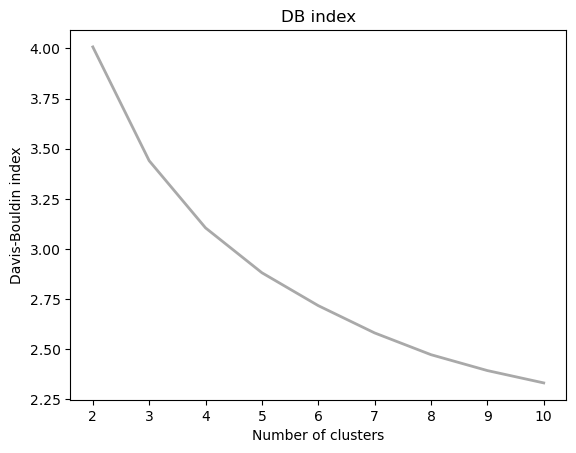

In [8]:
plt.plot(np.arange(2,11),dbis,color='darkgray',lw=2)
plt.xlabel('Number of clusters')
plt.ylabel('Davis-Bouldin index')
plt.title('DB index')
# plt.savefig(f'{path_figures}DBI.png',bbox_inches='tight')

Text(0.5, 1.0, 'Intercluster maximum correlation')

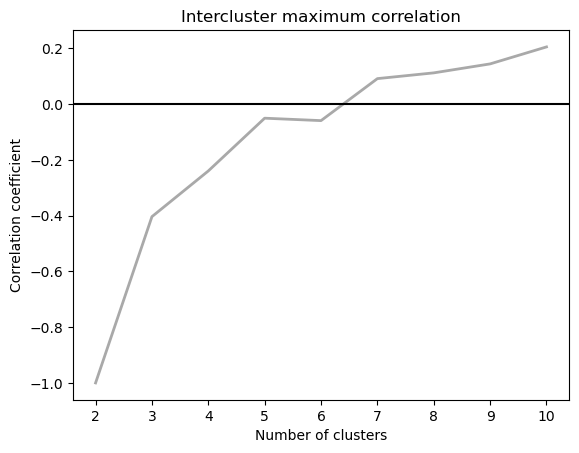

In [9]:
# plt.plot(np.arange(2,11),maxcorrs,color='darkgray',lw=2)

# plt.axhline(0,color='k')
# plt.xlabel('Number of clusters')
# plt.ylabel('Correlation coefficient')
# plt.title('Intercluster maximum correlation')
# # plt.savefig(f'{path_figures}Corr.png',bbox_inches='tight')

In [47]:
# # train kmeans
# k_means = KMeans(n_clusters=5,
#                  init='k-means++',
#                  verbose=1,
#                  random_state=11,
#                  n_init=500,
#                  max_iter=500)
# k_means.fit(pcs.values)
# clusters_centers = k_means.cluster_centers_
# labels = k_means.labels_

Initialization complete
Iteration 0, inertia 394583.96973725484.
Iteration 1, inertia 316627.05282531533.
Iteration 2, inertia 315117.64082898124.
Iteration 3, inertia 314454.71939185384.
Iteration 4, inertia 314072.5213013184.
Iteration 5, inertia 313786.71554234007.
Iteration 6, inertia 313525.46363195265.
Iteration 7, inertia 313285.22785888455.
Iteration 8, inertia 313089.9728623747.
Iteration 9, inertia 312929.3376491936.
Iteration 10, inertia 312780.4298969201.
Iteration 11, inertia 312642.23620791454.
Iteration 12, inertia 312491.81517769006.
Iteration 13, inertia 312331.63704776263.
Iteration 14, inertia 312182.0877899955.
Iteration 15, inertia 312038.91894469626.
Iteration 16, inertia 311896.7164054795.
Iteration 17, inertia 311755.18221490015.
Iteration 18, inertia 311627.67424927896.
Iteration 19, inertia 311514.68525192176.
Iteration 20, inertia 311410.7555227633.
Iteration 21, inertia 311311.8940262464.
Iteration 22, inertia 311217.02912968013.
Iteration 23, inertia 311125

In [48]:
# with open('kmeans_models/k_means_model_era5.pkl','wb') as f:
#     pickle.dump(k_means,f)

In [93]:
# cluster_centers = np.vstack([clusters_centers,np.zeros(12)])
# distances = euclidean_distances(cluster_centers, pcs.values)
# new_labels = distances.argmin(axis=0)
# df_labels = pd.DataFrame(new_labels,index=pcs.index)

In [94]:
# df_labels.columns=['WR']
# df_labels['distances'] = distances.min(axis=0)
# corrs = np.array([np.corrcoef(pcs.values[i],cluster_centers[df_labels['WR'].iloc[i]])[0,1] for i in range(len(df_labels))])
# df_labels['corr'] = corrs

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [95]:
# df_labels.to_csv(f'labels/df_labels_nocorrfilt_{reanalysis}.csv')

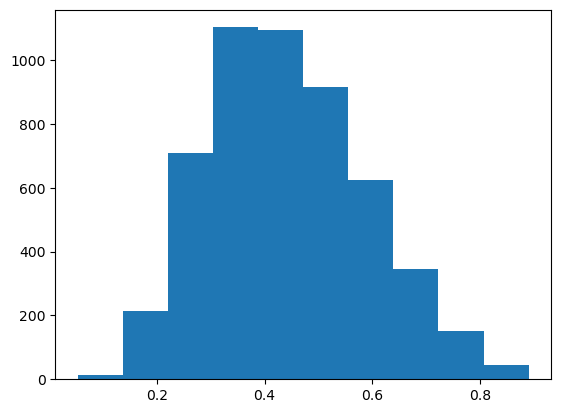

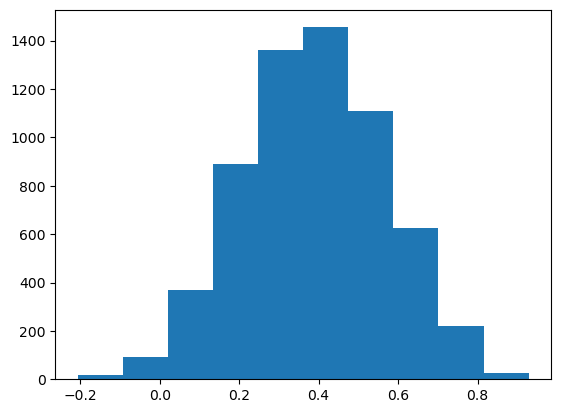

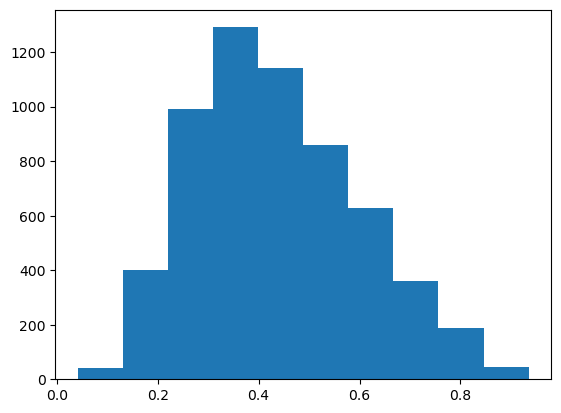

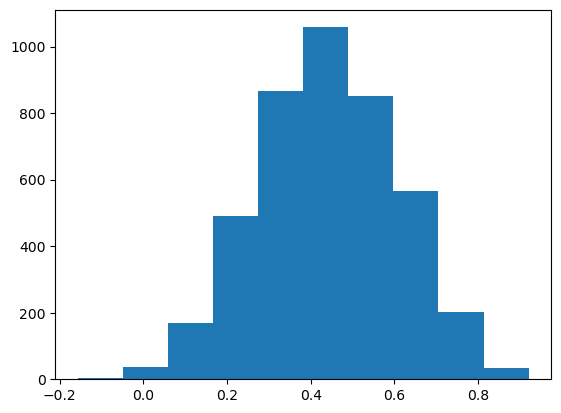

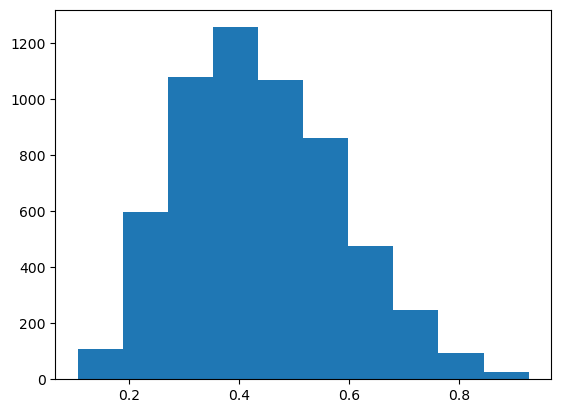

In [90]:
# for wr in np.unique(df_labels['WR'])[:-1]:
#     df_labels[df_labels['WR'] == wr]
#     plt.hist(df_labels[df_labels['WR'] == wr]['corr'])
#     plt.show()
#     plt.close()

In [96]:
# df_labels.loc[df_labels['corr']<=0.25,'WR']=np.unique(df_labels['WR'])[-1]

In [97]:
# df_labels.to_csv(f'labels/df_labels_{reanalysis}.csv')

# WRs for the other reanalyses

In [98]:
# for reanalysis in names_reanalyses[1:]:
#     pcs = pd.read_csv(f'{path_pcs}/PCs_{reanalysis}_corrected.csv',
#                   index_col=0,parse_dates=True, names=np.arange(0,12),skiprows=1)
#     distances = euclidean_distances(cluster_centers, pcs.values)
#     new_labels = distances.argmin(axis=0)
#     df_labels = pd.DataFrame(new_labels,index=pcs.index)
#     df_labels.columns=['WR']
#     df_labels['distances'] = distances.min(axis=0)
#     corrs = np.array([np.corrcoef(pcs.values[i],cluster_centers[df_labels['WR'].iloc[i]])[0,1] for i in range(len(df_labels))])
#     df_labels['corr'] = corrs
#     df_labels.to_csv(f'labels/df_labels_nocorrfilt_{reanalysis}.csv')
#     df_labels.loc[df_labels['corr']<=0.25,'WR']=np.unique(df_labels['WR'])[-1]
#     df_labels.to_csv(f'labels/df_labels_{reanalysis}.csv')

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Accuracy among reanalyses

In [8]:
import seaborn as sns

In [9]:
dic_labels = {}
for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'labels/df_labels_{reanalysis}.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances','corr'], skiprows=1)
    dic_labels[reanalysis] = labels_temp[['WR']]

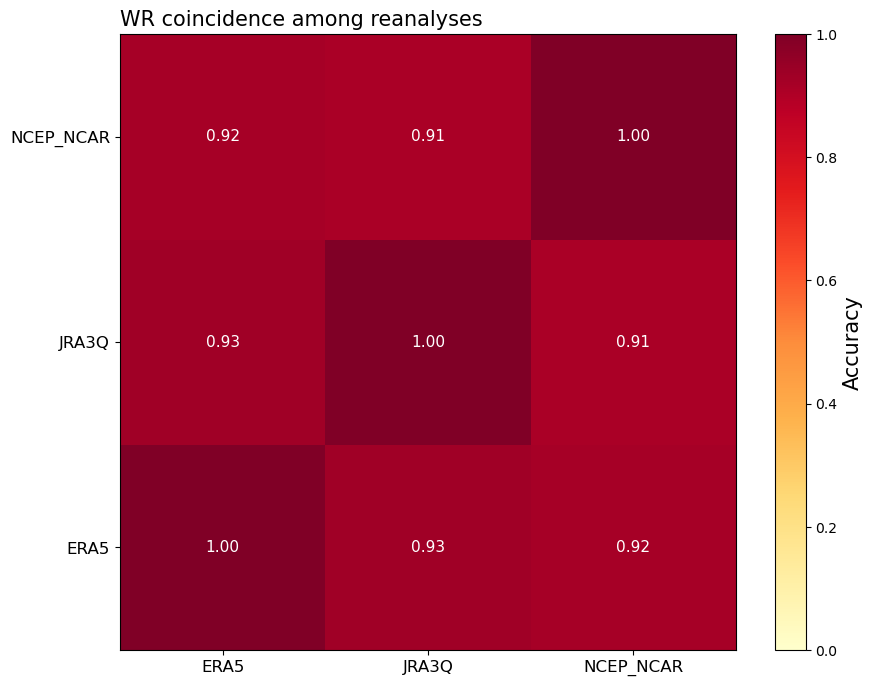

In [10]:
# Function to compute accuracy
def compute_accuracy(series1, series2):
    return np.mean(series1 == series2)

# Function to align and compute accuracy matrix
def compute_accuracy_matrix():
    df_combined = pd.DataFrame()
    accuracy_matrix = pd.DataFrame(index=names_reanalyses, columns=names_reanalyses)
    
    for i, reanalysis1 in enumerate(names_reanalyses):
        for j, reanalysis2 in enumerate(names_reanalyses):
            if i <= j:  # Compute only for upper triangle and diagonal
                df_combined = pd.concat([dic_labels[reanalysis1], dic_labels[reanalysis2]], axis=1, join='inner').dropna()
                accuracy = compute_accuracy(df_combined.iloc[:, 0], df_combined.iloc[:, 1])
                accuracy_matrix.loc[reanalysis1, reanalysis2] = accuracy
                accuracy_matrix.loc[reanalysis2, reanalysis1] = accuracy  # Mirror value to lower triangle
    
    return accuracy_matrix.astype(float)

# Compute and plot accuracy matrix
accuracy_matrix = compute_accuracy_matrix()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(accuracy_matrix, cmap='YlOrRd', vmin=0, vmax=1, origin='lower',)

# Add colorbar
cbar = fig.colorbar(cax)
cbar.set_label('Accuracy', fontsize=15)  # Set colorbar label and fontsize

# Set ticks and labels
ax.set_xticks(np.arange(len(names_reanalyses)))
ax.set_yticks(np.arange(len(names_reanalyses)))
ax.set_xticklabels(names_reanalyses, fontsize=12)
ax.set_yticklabels(names_reanalyses, fontsize=12)

# Set x-axis ticks position to bottom
ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_label_position('bottom')

# # Rotate the x tick labels if necessary
# plt.xticks(rotation=90)

# Add annotations
for i in range(len(names_reanalyses)):
    for j in range(len(names_reanalyses)):
        text = ax.text(j, i, f'{accuracy_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='white',fontsize=11)

plt.title('WR coincidence among reanalyses', fontsize=15,loc='left')
plt.savefig('Figures/CoincidenceAmongWRs.png',bbox_inches='tight')

# Compute composites

In [11]:
def get_average_fields_for_centroids(dataarray,labels):
    wrs = np.unique(labels)
    avgs = []
    for wr in wrs:
        df_wr = labels[labels['WR']==wr]
        arr_selection = dataarray.sel(time=df_wr.index)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return xr.concat(avgs,dim='WR')

In [17]:
# for reanalysis in names_reanalyses:
for reanalysis in ['ERA5']:
    anoms = xr.open_dataset(f'{path_anoms}Z500Anoms_{reanalysis}.nc')
    labels_temp = pd.read_csv(f'labels/df_labels_{reanalysis}.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances','corr'], skiprows=1)
    labels_temp.loc[labels_temp['corr']<=0.25,'WR']=np.unique(labels_temp['WR'])[-1]
    composites = get_average_fields_for_centroids(anoms, labels_temp[['WR']])
    composites.to_netcdf(f'composites/composites_{reanalysis}_March23_2025.nc')

In [18]:
del(anoms)

# Plot composites

In [121]:
def plot_composite_grid(dic_composites, dic_freqs, regioncoords, names=None, n_cols=3, path_save=None):
    min_lon, max_lon, min_lat, max_lat = regioncoords
    n_reanalyses = len(dic_composites)
    n_clusters = len(dic_composites[list(dic_composites.keys())[0]].WR)-1
    
    # Determine the number of rows needed
    n_rows = n_clusters
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 1.5 * n_rows),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
    
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each reanalysis in the grid
    letter_idx = 0  # Start the letter index
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]
            reanalysis = list(dic_composites.keys())[j]
            da = dic_composites[reanalysis]
            freqs_labels = dic_freqs[reanalysis]
            
            # Convert longitudes to -180 to 180 range
            lon = (da.lon + 180) % 360 - 180
            
            # Adjust data array to match the longitude range
            da_shifted, lon_shifted = xr.broadcast(da, lon)
            
            # # Plot the rectangle to highlight the specified region
            # rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha': 0.2}
            # if min_lon < max_lon:
            #     ax.add_patch(plt.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
            #                                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            # else:
            #     ax.add_patch(plt.Rectangle((min_lon, min_lat), 180 - min_lon, max_lat - min_lat,
            #                                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            #     ax.add_patch(plt.Rectangle((-180, min_lat), max_lon + 180, max_lat - min_lat,
            #                                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            
            ax.set_extent([-100, 90, 10, 90], crs=ccrs.PlateCarree(central_longitude=-100))
            
            # Add gridlines every 20 degrees
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
            gl.xlocator = plt.FixedLocator(np.arange(-180, 180, 30))
            gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
            gl.top_labels = False
            gl.right_labels = False
            gl.xformatter = LongitudeFormatter(zero_direction_label=True)
            gl.yformatter = LatitudeFormatter()
            
            tick_fontsize = 8
            gl.xlabel_style = {'size': tick_fontsize}
            gl.ylabel_style = {'size': tick_fontsize}
            
            mini=-2.5
            maxi=2.5
            intervals = 21
            bounds=np.linspace(mini,maxi,intervals)
            
            # Plot the data using pcolormesh
            mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anom.values,
                               levels=bounds, vmin=mini, vmax=maxi,
                                cmap='RdYlBu_r', transform=ccrs.PlateCarree(),extend='both')
            
            # Add coastlines for context
            ax.coastlines()

            # Generate the letter for the current subplot
            letter = chr(97 + letter_idx)  # 'a' = 97 in ASCII
            letter_idx += 1

            if names:
                ax.set_title(f'({letter}) {names[i]} - Freq.: {np.round(freqs_labels[i], 2)}%', fontsize=10, loc='left')
            else:
                ax.set_title(f'({letter}) Cluster {i+1} - Freq.: {np.round(freqs_labels[i], 2)}%', fontsize=10, loc='left')
    
    # Add reanalysis names as column titles
    letter_idx = 0
    for j, reanalysis in enumerate(dic_composites.keys()):
        freqs_labels = dic_freqs[reanalysis]
        letter = chr(97 + letter_idx)  # 'a' = 97 in ASCII
        letter_idx += 1
        axes[0, j].set_title(f'{reanalysis}\n({letter}) {names[0]} - Freq.: {np.round(freqs_labels[0], 2)}%', fontsize=10, loc='left')
    
    plt.tight_layout()
    
    # Add a horizontal colorbar for all subplots
    cax = fig.add_axes([0.3, -0.02, 0.4, 0.02])
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')
    
    if path_save:
        plt.savefig(path_save, bbox_inches='tight', dpi=200)
    else:
        plt.show()
        plt.close('all')

In [122]:
dic_composites = {}
dic_frequencies = {}

for reanalysis in names_reanalyses:
    labels_temp = pd.read_csv(f'labels/df_labels_{reanalysis}.csv', 
                              parse_dates=True, index_col=0, names=['WR','distances','corr'], skiprows=1)[['WR']]
    composites = xr.open_dataset(f'composites/composites_{reanalysis}.nc')
    frequencies_percent = labels_temp['WR'].value_counts(normalize=True) * 100
    frequencies_percent = frequencies_percent.sort_index().values
    dic_frequencies[reanalysis] = frequencies_percent
    dic_composites[reanalysis] = composites
region = [180, 330, 20, 80]
# names = ["Atlantic High","Greenland High","Pacific Ridge","Pacific Trough","No WR"]
names = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

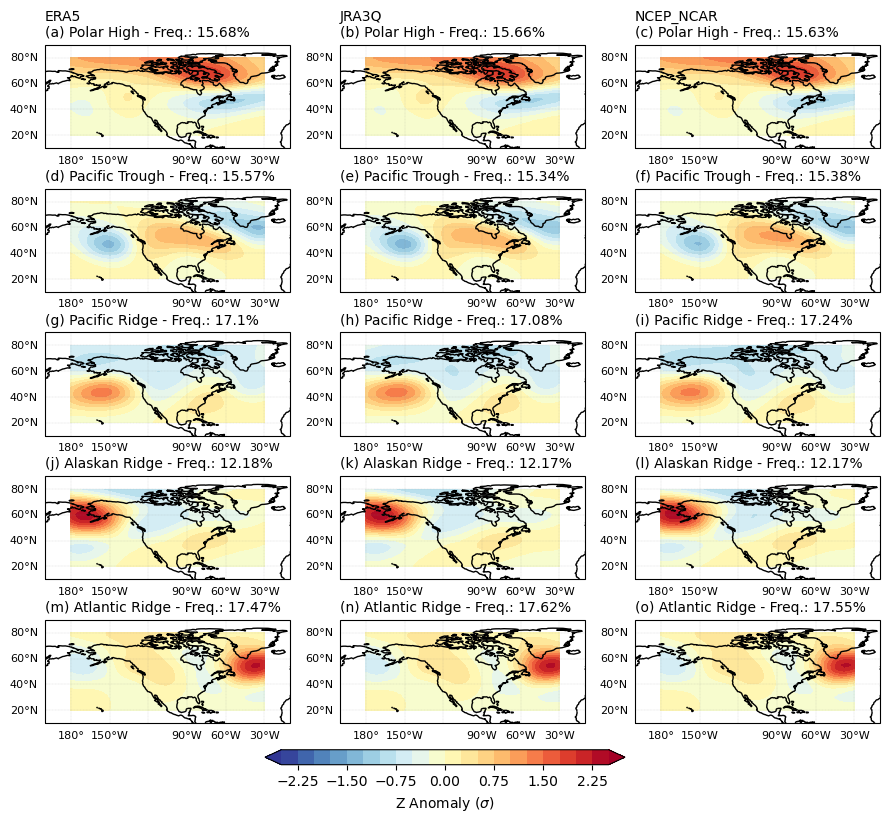

In [123]:
# Example usage:
plot_composite_grid(dic_composites, dic_frequencies, regioncoords=region,
                    names=names,path_save=f'Figures/Composites_All.png')

In [23]:
def plot_multiple_maps(da,regioncoords,names = None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da.WR)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(da.WR.values)-1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)
        
        # # Plot the rectangle to highlight the specified region
        # rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha':0.2}
        
        # if min_lon_converted < max_lon_converted:
        #     # Normal case, region does not cross the antimeridian
        #     ax.add_patch(plt.Rectangle(
        #         (min_lon_converted, min_lat), max_lon_converted - min_lon_converted, max_lat - min_lat,
        #         transform=ccrs.PlateCarree(), **rect_style, zorder=2))
        # else:
        #     # Special case for regions crossing the antimeridian
        #     ax.add_patch(plt.Rectangle(
        #         (min_lon_converted, min_lat), 180 - min_lon_converted, max_lat - min_lat,
        #         transform=ccrs.PlateCarree(), **rect_style, zorder=2))
        #     ax.add_patch(plt.Rectangle(
        #         (-180, min_lat), max_lon_converted + 180, max_lat - min_lat,
        #         transform=ccrs.PlateCarree(), **rect_style, zorder=2))

        ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-1
        maxi=1
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        mesh = ax.contourf(lon_shifted.sel(WR=i).lon, da.lat, da_shifted.sel(WR=i).Z_anom.values, levels=bounds, vmin=mini, vmax=maxi,
                                 cmap='bwr', transform=ccrs.PlateCarree(),extend='both')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]}',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1}',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.55, 0.22, 0.4, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if path_save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=100)
        plt.close('all')

In [25]:
region = [180, 330, 20, 80]
# names = ["Atlantic High","Greenland High","Pacific Ridge","Pacific Trough","No WR"]
names = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]
plot_multiple_maps(composites,
                   region,names=names, path_save=f'../ScriptsFiguresPaper/Figures/Methods_Composites_ERA5.png')